# [Run Notebook on DeepNote](https://deepnote.com/project/f705a513-f45c-4485-a0d7-f9cbd1260dc8)
# Table of Contents:
1. [Data](#data)

1. [Feature Engineering](#feature_engineering)

1. [Algorithms & Search](#alg_search)

1. [Evaluation Metrics](#metrics)

1. [Ensemble Learning](#ensemble)

1. [Final Model Selection and Evaluation](#final_model)

1. [Results](#results)

1. [Conclusion](#conclusion)

In [1]:
# Imports
import  numpy             as np
import  pandas            as pd
import  matplotlib.pyplot as plt
import  warnings
warnings.filterwarnings('ignore')


# Feature Engineering
from    category_encoders          import OneHotEncoder, OrdinalEncoder
from    sklearn.experimental       import enable_iterative_imputer
from    sklearn.impute             import IterativeImputer, SimpleImputer
from    sklearn.base               import TransformerMixin
from    sklearn.base               import BaseEstimator
from    sklearn.preprocessing      import QuantileTransformer, StandardScaler
from    sklearn.compose            import ColumnTransformer

# Cross Validation and PipeLine
from    sklearn.model_selection    import RandomizedSearchCV, cross_val_score
from    sklearn.pipeline           import Pipeline

# Models
from    sklearn.ensemble           import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier, \
                                          GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from    sklearn.neighbors          import KNeighborsClassifier
from    sklearn.linear_model       import LogisticRegression, SGDClassifier
from    sklearn.svm                import LinearSVC

# Model Evaluation
from    sklearn.metrics            import balanced_accuracy_score, f1_score, plot_confusion_matrix, precision_score, recall_score,accuracy_score
from    sklearn.inspection         import permutation_importance


# Hypothetical Scenario: [Kaggle](https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists)
____
"A company which is active in Big Data and Data Science wants to hire data scientists among people who successfully pass some courses which conduct by the company. Many people signup for their training. Company wants to know which of these candidates are really wants to work for the company after training or looking for a new employment because it helps to reduce the cost and time as well as the quality of training or planning the courses and categorization of candidates. Information related to demographics, education, experience are in hands from candidates signup and enrollment.

This dataset designed to understand the factors that lead a person to leave current job for HR researches too. By model(s) that uses the current credentials,demographics,experience data you will predict the probability of a candidate to look for a new job or will work for the company, as well as interpreting affected factors on employee decision."
_____
# Research Question:
_____
**Given information about an individual, can we predict whether or not they are currently looking for a new job?**
_________


# Data <a id='data'></a> 
_________
**Note that our data is imbalanced. 25% of the observations have the target = 1.**

The data we will be looking at includes 12 different features:
#### Numerical Columns:
1. ```city_development_index``` : Float from 0-1
2. ```training_hours```: Number of hours trained

#### Categorical:
1. ```city```: 123 diff cities
2. ```gender```: 4 genders: 'Male', 'Female', 'Other', nan
1.  ```enrolled_university```: 'no_enrollment', 'Full time course', nan, 'Part time course'
2.  ```education_level```: 'Graduate', 'Masters', 'High School', nan, 'Phd', 'Primary School'
3. ```company_size```: nan, '50-99', '<10', '10000+', '5000-9999', '1000-4999', '10/49','100-500', '500-999'
3. ```relevent_experience```: 'Has relevent experience', 'No relevent experience'
6. ```major_discipline```: 'STEM', 'Business Degree', nan, 'Arts', 'Humanities', 'No Major', 'Other'
8. ```last_new_job```: nan, 'never', 1,2,3,4, >4
7. ```company_type```: 'Early Stage Startup', 'Funded Startup', 'NGO', 'Other', 'Public Sector', 'Pvt Ltd', nan


#### Ordinal Categorical:
1. ```experience```:  nan, <1, 1 through 20, >20


#### Target
1. ```target```: 1 = "Looking for a Job", 0 = "Not Looking for a Job"
__________

In [2]:
df = pd.read_csv('HR_Analytics/aug_train.csv')
y = df['target'] 
X = df.drop('target', axis=1)
X.shape, y.shape

((19158, 13), (19158,))

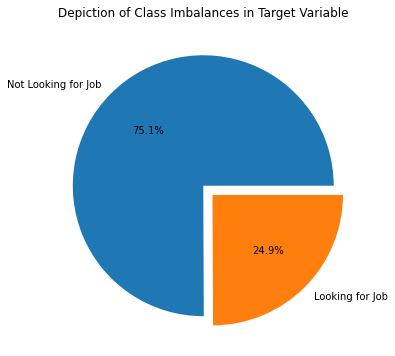

In [66]:
fig, ax = plt.subplots(figsize = (6,6))

_, sizes = np.unique(y, return_counts=True)
labels = ['Not Looking for Job','Looking for Job']
ax.pie(sizes, explode=(0,0.1), labels=labels, autopct='%1.1f%%')
ax.set_title('Depiction of Class Imbalances in Target Variable')
plt.show();

# Feature Engineering and Preprocessing Pipeline <a id='feature_engineering'></a>
   ____________
For this model, we divide our features into 2 main categories: Numerical and Categorical. This is in order to create a preprocessing pipeline that could correctly deal with missing values **in an appropriate way**. 
- **Categorical Preprocessing:** 
    1. The first step in this pipeline is to use a **```SimpleImputer```** to fill in the missing values (np.NaN) with "missing". Although there are many other strategies to use when filling in missing values, there could be underlying reasons in the data collection why an observation has missing data. Therefore, to simply fill in the missing values with the most_frequent of the data would be adding bias from us, the researcher. Without knowing more about why these values are np.nan, we can just fill in the value with "missing" for categorical features. 
    2. We then pipe this into a **```OneHotEncoder```** in order to encode each variable's values as a separate binary column.
    3. Note that after further testing, I've decided to OneHotEncode the ordinal features as well. I did not notice an impact on the model itself when mapping the ordinal features individually to their relative values.
    
    
    
- **Numerical Preprocessing:**
    1. Instead of using a SimpleImputer, I choose to use an **```IterativeImputer```** instead. The IterativeImputer tries to mimic R's MICE package (Multivariate Imputation by Chained Equations). I decided to use this because I felt that it would be a better solution than the SimpleImputer because:
        1. Can't fill in the values with "missing" since that affects the pipeline when trying to standardize the columns.
        2. [It is a step in dealing with the problem of increased noise due to imputation](https://en.wikipedia.org/wiki/Imputation_(statistics))
    2. Next, we use a **```StandardScalar```** to normalize our data. Due to the fact that neither of my numerical columns have any severe outliers, this is preferred over a RobustScalar. In addition, the normalizing helps bring both features within a similar range.
    3. Finally, due to the fact that many ML algorithms can perform better when the numerical features have a Gaussian distribution, we use a **```QuantileTransformer```**

_________

In [6]:
# Our categorical column we want to OneHotEncoder
cat_cols = ['city', 'gender', 'enrolled_university', 'major_discipline', 'experience', 'last_new_job', 
            'company_type', 'company_size', 'education_level', 'relevent_experience']


# Our numerical columns
num_cols = ['city_development_index', 'training_hours']


# Categorical Pipeline
cat_pipe = Pipeline([("impute", SimpleImputer(missing_values=np.nan, fill_value='missing', strategy="constant")),
                     ("encode", OneHotEncoder())])


# Numerical Pipeline
num_pipe = Pipeline([("impute", IterativeImputer(missing_values=np.nan, max_iter=10, initial_strategy="median")),
                     ("scaler", StandardScaler()),
                     ("transformer", QuantileTransformer(output_distribution='normal'))])

# Group them together with ColumnTransformer
preprocessing = ColumnTransformer([('categorical', cat_pipe, cat_cols),
                                   ('numerical', num_pipe, num_cols)])


# Algorithms & Search <a id='alg_search'></a>
_______
For this section, I chose a few algorithms to include in my __```RandomizedSearchCV```__:
   1. **```RandomForestClassifier```**
       1. Why: This was a ML model that I learned in my Intro to ML class. It seemed like a very good contester for this problem because it uses multiple decision trees (that individually tend to overfit on training data) and aggregates their predictions in order to decrease the variance of the model.
       2. Hyperparamater Tuning:
           - **Min Samples Leaf**: ```np.linspace(1,10,4)```
               - Min samples per leaf is a good hyperparameter to help each decision tree make more generalizable predictions. Note that the default is 1, which can lead to decision trees overfitting to the training data.
           - **Bootstrap**: ```[True, False]```
               - When Bootstrap is True, it means that each decision tree is shown a sample of the training data. This is an attempt to create "dumber" decision trees in order to have a better, generalized model. Note that this parameter is dependent on **max_samples** which we set to a small k (between 5 and 20). 
           - **Class Weight**: ```[None, 'balanced', 'balanced_subsample']```
               - Since our data is imbalanced, we want to include a variety of class_weights. Note that since we are not performing SMOTE, I can assume that the class weight will either be balanced or a balanced_subsample. 
           - **Number of Estimators**: ```np.linspace(25,200,4)```
              - Here I choose a variety of different number of estimators. These represent the number of decision trees that make up our "RandomForest". The larger the number can potentially lead to decreasing the variance of our model. 
           - **Max Samples**:  ```np.linspace(0.1, 0.9, 5)```
              - This variable is dependent on bootstrap=True. For each base estimator, it will sample between 10-90% of X for training. If bootstrap=False. the whole data will be used to train each tree.
           - **Max Features**: ```['auto', 'sqrt', 'log2']```
              - For each split in each node, this feature represents the derivation needed to figure out the number of features to take into consideration. We want to make sure it chooses m features where m has a high enough probability to use at least one "predictive" feature.
         
              
   2. **```LinearSVC```**
       1. Why: Since this is a binary problem (we are predicting 1s and 0s), SVM can perform better than RandomForests (which is intrinsically situated for multi-class problems). In addition, SVM models can also have an advantage to more sparse data, which, with the OneHotEncoder, could prove to be useful. Finally, I decided to use a LinearSVC because it trains much quicker than the traditional SVC.
           ![As we can see in the above image, SVC is extremely slow](Images/SGD_Comparison.png)
                               - As we can see in the above image, SVC is extremely slow
       
       2. Hyperparameter Tuning:
           - **Class Weight**: ```['balanced', None]```
               - Similarly to my decision in RFClassification, I include both 'balanced' and None for the class weight of my SVC model
           - **C**: ```np.linspace(0.001, 10, 10)```
               - In an attempt to test different regularization weights, I set C to values between 1 and 100.
       
       
   3. **```KNeighborsClassifier```**
       1. Why: I included KNN because I felt like it was a fairly different algorithm from the Trees and could be interesting to see how it performs. 
       2. Hyperparameter Tuning:
           - **Number of Neighbors**: ```np.linspace(3, 13, 3)```
               - Tweaking the number of neighbors impacts the amount of neighbors we need to look at before classifying our observation.
           - **Weights**: ```['uniform', 'distance']```
               - Distance: Closer neighbors will have a higher influence on the classification than further neighbors.
               - Uniform: Both close and far neighbors have the same weight.
           - **p**: ```[1,2]```
               - p = 1 -> Manhattan Distance
               - p = 2 -> Euclidean distance
               
               
   4. **```ExtraTreesClassifier```**
       1. Why: This has a much faster implementation than RandomForestClassifier. This is due to the fact that ExtraTrees chooses its split point threshold's randomly versus RandomForest's more iterative approach.
       2. Hyperparameter Tuning:
           - This has the same hyperparameter tuning decisions as my RandomForestClassifier
           
           
   5. **```LogisticRegression```**
       1. Why: I included logistic regression in order to see how it performs vs. RandomForest. Logistic Regression, in general, is much quicker to train and much easier to interpret than Random Forests.
       2. Hyperparameter Tuning:
           - **Class Weight**: ```['balanced', None]```
               - Similarly to my decision in RFClassification, I include both 'balanced' and None for the class weight of my LogisticRegression model
           - **Solver**: ```['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']```
               - I included a variety of different solvers as these tend to be data-dependent and it is good to try a variety. Note that since my problem is not a multiclass problem, I am able to include all of these solvers.
           - **Penalty**: ```['l1', 'l2', 'elasticnet', 'none']```
               - This represents the penalty used in my loss function.
               
_______

# Evaluation Metrics <a id='metrics'></a>
__________
I decided to use a **weighted f1 score** as my metric since my data is imbalanced.  It is equally important for this business to correctly predict those looking for work (Precision) while maintaining a high Recall Rate (we aren't missing potential job-seeking individuals). This priority is due to a focus on resource allocation. If a business wants to reach out to individuals that are currently looking for jobs, we want to use a model that efficiently allocates their resources (recruiters) by avoiding reaching out to False Positives and making sure we don't miss any True Positives.

In [7]:
# Helper class
class DummyEstimator(BaseEstimator):
    "Pass through class, methods are present but do nothing."
    def fit(self): pass
    def score(self): pass

In [8]:
np.random.seed(1)  # Use a random seed to have consistent results

pipe = Pipeline([("preprocessing", preprocessing),
                 ("clf", DummyEstimator())])

search_space = [
            {'clf': [ExtraTreesClassifier(n_jobs=-1)], 
                'clf__min_samples_leaf': np.linspace(1, 30, 4, dtype=int),
                'clf__bootstrap': [True, False],
                'clf__max_samples': np.linspace(5, 30, 4, dtype=int), 
                'clf__class_weight': [None, 'balanced', 'balanced_subsample'],
                'clf__n_estimators': np.linspace(25, 200, 4, dtype=int)},
                
            {'clf': [RandomForestClassifier(n_jobs=-1)], 
                'clf__min_samples_leaf': np.linspace(1, 10, 4, dtype=int),
                'clf__bootstrap': [True, False],
                'clf__max_samples': np.linspace(0.1, 0.9, 5),
                'clf__class_weight': [None, 'balanced', 'balanced_subsample'],
                'clf__max_features': ['auto', 'sqrt', 'log2'],
                'clf__n_estimators': np.linspace(25, 200, 4, dtype=int)},
               
            {'clf': [KNeighborsClassifier(n_jobs=-1)],
                'clf__n_neighbors': np.linspace(3, 13, 3, dtype=int),
                'clf__weights': ['uniform', 'distance'],
                'clf__p': [1,2]},
               
            {'clf': [LinearSVC()],  
                'clf__class_weight': ['balanced', None],
                'clf__C': np.linspace(0.001, 10, 10)},
               
            {'clf': [LogisticRegression(n_jobs=-1)],  
                'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'clf__class_weight': ['balanced', None],
                'clf__penalty': ['l1', 'l2', 'elasticnet', 'none']},

            {'clf': [SGDClassifier(n_jobs=-1)],  
                'clf__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
                'clf__class_weight': ['balanced', None],
                'clf__penalty': ['l1', 'l2', 'elasticnet']}]

# Create grid search 
gs = RandomizedSearchCV(pipe, 
                        search_space, 
                        scoring='f1_weighted',
                        n_iter=50,
                        cv=5,
                        n_jobs=-1)

gs.fit(X, y);

In [9]:
print(f'Best Weighted F1 Score: {gs.best_score_:.3f}\n\nBest Model: {gs.best_params_["clf"]}')

Best Weighted F1 Score: 0.797

Best Model: RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       max_samples=0.1, min_samples_leaf=4, n_estimators=83,
                       n_jobs=-1)


# RandomizedSearchCV Results: 
Best Model:
```python
# Before
RandomForestClassifier(bootstrap=False,  # No bootstrapping
                       max_samples=0.1,   # Percent of samples to be trained on
                       class_weight='balanced_subsample',  # Good because our data is imbalanced
                       min_samples_leaf=4,  # Increasing can improve generalizability if we are overfitting
                       n_estimators=83,  # Plenty of trees to train
                       n_jobs=-1)

```
Weighted F1 Score: ``` 0.797```

**Note**:
- We notice that bootstrapping let to a worse cross-validated Weighted F1 score.
- In addition, with bootstrapping=False, that means that class_weight being 'balanced_subsample' is the same as 'balanced'. It also means that we are not actually using our max_samples parameter and can remove it.
- In addition, our min_samples_leaf was 4, which helps weaken the individual decision trees, but increase model generalizability (decreases variance)
- The class_weight being balanced which makes sense because our data is imbalanced and the model needs to add weights to the different labels. This can lead to a higher recall score and a lower precision score.
   
```python
# After
RandomForestClassifier(bootstrap=False,  # No bootstrapping
                       class_weight='balanced',  # Good because our data is imbalanced
                       min_samples_leaf=4,  # Increasing can improve generalizability if we are overfitting
                       n_estimators=83,  # Plenty of trees to train
                       n_jobs=-1)

```

_________
# Ensemble Learning <a id='ensemble'></a>
_______
In order to further improve our model, we can look into ensemble learning as a way to improve our metric (f1_weighted). Note that we will be primarily looking at:
1. VotingClassifier()
    - VotingClassifier combines multiple machine learning models and takes the most common prediction ("Hard Voting") or the probability-weighted average of the individual learners ("Soft Voting").
2. Bagging
    - Bagging is useful because it tends to reduce the time of each individual model and improve the overall generality. In addition, it can be used with a variety of different models.
3. Boosting
    - Boosting has shown a lot of promise in improving model metrics the most (at least what I've read online). Therefore, I predict that this may lead to my best evaluation metric.
________

In [18]:
np.random.seed(1)
#Helper Function for displaying results of cross_val_score
def print_val_score(res, name):
    mean   = np.mean(res)
    std    = np.std(res)
    print(f"{name:<11} -> Mean: {mean:.3f}  |  Std: {std:.3f}")
    
    
# Calculate the general stats for our first model to have a way to compare other methods
rfc_clf =  RandomForestClassifier(bootstrap=False, 
                                  class_weight='balanced',
                                  min_samples_leaf=4, 
                                  n_estimators=83,
                                  n_jobs=-1)


pipe = Pipeline([('preprocessing', preprocessing),
                  ('model', rfc_clf)])

scores = []

scores.append(cross_val_score(pipe, X, y, cv=5, scoring='f1_weighted'))
scores.append(cross_val_score(pipe, X, y, cv=5, scoring='recall'))
scores.append(cross_val_score(pipe, X, y, cv=5, scoring='precision'))

names = ['weighted F1', 'recall', 'precision']
for score, name in zip(scores, names):
    print_val_score(score, name)
    

weighted F1 -> Mean: 0.796  |  Std: 0.006
recall      -> Mean: 0.733  |  Std: 0.004
precision   -> Mean: 0.557  |  Std: 0.011


# Voting Classifier:
_______
In this section, I simply combine 4 different models:
1. My best model from my previous randomizedSearchCV
2. A Logistic Regression model
3. An ExtraTreesClassifier
   - Note that the top two models were chosen through repeated iterations of my randomizedSearchCV where I removed the best performer at each step to see the "next best model".
4. A bootstrapped RandomForestClassifier (A weaker version of my first model, but can maybe help generalize more).

In [19]:
np.random.seed(1)

# Different Models that I will be using:
rfc_clf =  RandomForestClassifier(bootstrap=False, 
                                  class_weight='balanced',
                                  min_samples_leaf=4, 
                                  n_estimators=83,
                                  n_jobs=-1)

lr_clf  = LogisticRegression(class_weight='balanced', 
                             n_jobs=-1, 
                             solver='sag')

etc_clf = ExtraTreesClassifier(class_weight='balanced', 
                               max_samples=20,
                               min_samples_leaf=10, 
                               n_estimators=50, 
                               n_jobs=-1)


rfc_clf_2 = RandomForestClassifier(bootstrap=True, 
                                   max_samples=0.63,
                                   class_weight='balanced',
                                   min_samples_leaf=10, 
                                   n_estimators=50,
                                   n_jobs=-1)


# Different pipelines
pipe1 = Pipeline([('preprocessing', preprocessing),
                  ('model', rfc_clf)])

pipe2 = Pipeline([('preprocessing', preprocessing),
                  ('model', lr_clf)])

pipe3= Pipeline([('preprocessing', preprocessing),
                  ('model', etc_clf)])

pipe4 = Pipeline([('preprocessing', preprocessing),
                  ('model', rfc_clf_2)])

estimators = [('rfc', pipe1),
              ('lr', pipe2),
              ('etc', pipe3),
             ('rtc_2', pipe4)]

# Initialize my VotingClassifier
voting_clf = VotingClassifier(estimators = estimators,
                                  voting = 'soft', 
                              weights=[2/5, 1/5, 1/5, 1/5],
                             n_jobs=-1)

# Use Cross_val_score to see how well my model performs:
scores = []

scores.append(cross_val_score(voting_clf, X, y, cv=5, scoring='f1_weighted'))
scores.append(cross_val_score(voting_clf, X, y, cv=5, scoring='recall'))
scores.append(cross_val_score(voting_clf, X, y, cv=5, scoring='precision'))

names = ['Weighted F1', 'recall', 'precision']
for score, name in zip(scores, names):
    print_val_score(score, name)

Weighted F1 -> Mean: 0.794  |  Std: 0.006
recall      -> Mean: 0.742  |  Std: 0.005
precision   -> Mean: 0.549  |  Std: 0.010


## VotingClassifier Results:
    - As we can see, our weighted F1 score is pretty close to how our single RandomForestClassifier (RFC) performed.
    - Even when comparing the Precision and Recall scores, we see that neither model (VotingClassifier or RFC) were clear "winners".
    - Note that including a larger and more diverse amount of estimators could greatly improve this model.
_________
# Bagging:
___________
In this section, I experiment the use of bagging with my RandomForestClassifier parameters

In [20]:
np.random.seed(1)

bag = BaggingClassifier(rfc_clf,
                        n_estimators=11,
                        max_samples=0.8,
                        max_features=0.9,
                        oob_score=True)

bagging_pipe = Pipeline([('preprocessing', preprocessing),
                         ('model', bag)])

# Use Cross_val_score to see how well my model performs:
scores = []

scores.append(cross_val_score(bagging_pipe, X, y, cv=5, scoring='f1_weighted'))
scores.append(cross_val_score(bagging_pipe, X, y, cv=5, scoring='recall'))
scores.append(cross_val_score(bagging_pipe, X, y, cv=5, scoring='precision'))

names = ['Weighted F1', 'recall', 'precision']
for score, name in zip(scores, names):
    print_val_score(score, name)

Weighted F1 -> Mean: 0.797  |  Std: 0.006
recall      -> Mean: 0.734  |  Std: 0.006
precision   -> Mean: 0.559  |  Std: 0.012


## Bagging Results:
    - Similarly to VotingClassifier, the Bagging did not substantially improve the model's performance, nor did it decrease the model's standard deviation. I am sure with more hyper-parameter tuning I can improve upon this model.
    
_______
# Boosting
In this section, will look at implementing a gradient boosting machine, specifically using a GradientBoostingClassifier as my final estimator in my StackingClassifier.

__________
### GradientBoostingClassifier

In [21]:
np.random.seed(1)

final_estimator = GradientBoostingClassifier()

estimators = [('rfc', pipe1),
              ('lr', pipe2),
              ('etc', pipe3),
              ('rfc2', pipe4)]


boosted_stack = StackingClassifier(estimators=estimators,
                        final_estimator=final_estimator,
                         n_jobs=-1)



# Use Cross_val_score to see how well my model performs:
scores = []

scores.append(cross_val_score(boosted_stack, X, y, cv=5, scoring='f1_weighted'))
scores.append(cross_val_score(boosted_stack, X, y, cv=5, scoring='recall'))
scores.append(cross_val_score(boosted_stack, X, y, cv=5, error_score='raise', scoring='precision'))

names = ['f1_weighted', 'recall', 'precision']
for score, name in zip(scores, names):
    print_val_score(score, name)

f1_weighted -> Mean: 0.801  |  Std: 0.005
recall      -> Mean: 0.641  |  Std: 0.009
precision   -> Mean: 0.589  |  Std: 0.014


## Ensemble Model Results:

1. VotingClassifier():
    - Using RandomForestClassifier, LogisticRegression, and ExtraTreesClassifier, this strategy yielded similar results to my initial RandomForestClassifier.
    - Note that I used a 'soft' scoring since every one of my models include probabilities to serve as a metric of confidence in a prediction.
    - I decided to not use this method for my final model because it did not perform significantly better than my initial model.
    
    
2. Bagging:
    - Similarly, the results of using a BaggingClassifier was fairly similar to the simple RandomForestClassifier.
    - I decided to not use this model for my final model.


3. GradientBoostingClassifier():
    - This strategy, using a GradientBoostingClassifier as my final_estimator in a StackingClassifier gave me my best Weighted F1 score. That being said, its recall was almost 10% less than the other estimators with a marginally better precision score. 
___________

# Final Model Selection <a id='final_model'></a>
___________
Although I briefly looked at some ensemble techniques, I decided to stick with my original RandomForestClassifier **(RFC)** because of it's simultaneously high F! weighted score and recall. In addition, the RFC, compared to the ensemble techniques trained much quicker.
_______
## Specifications of the Final Model:


Our final model is a **RandomForestClassifier** with the following hyperparameters:

```python
RandomForestClassifier(bootstrap=False,  # No bootstrapping
                       class_weight='balanced',  # Good because our data is imbalanced
                       min_samples_leaf=4,  # Increasing can improve generalizability if we are overfitting
                       n_estimators=83,  # Plenty of trees to train
                       n_jobs=-1)

```

    - Note that since bootstrap=False, this model is training 83 decision trees with all the available data.
_________

**But wait, there's more!**
In order to fit our RandomForestClassifier on the data, we needed to first include our preprocessing steps.

This involved:
   1. Using OneHotEncoding on all categorical features after imputing "missing" values anywhere the data is not collected.
   
```python
cat_pipe = Pipeline([("impute", SimpleImputer(missing_values=np.nan, 
                                              fill_value='missing', 
                                              strategy="constant")),
                     ("encode", OneHotEncoder())])

```
   2. Use IterativeImputer for the numerical values, scale them, and then change their distribution into a Gaussian one.
   
```python
num_pipe = Pipeline([("impute", IterativeImputer(missing_values=np.nan, 
                                                 max_iter=10, 
                                                 initial_strategy="median")),
                     ("scaler", StandardScaler()),
                     ("transformer", QuantileTransformer(output_distribution='normal'))])

```
   3. Grouping them together with a ColumnTransformer().
```python
preprocessing = ColumnTransformer([("categorical", cat_pipe, cat_cols),
                                   ("numerical", num_pipe, num_cols)]) 


_____
## Evaluating the Final Model <a id='results'></a>
Now that we have a final model, we can:
   1. Predict on the test set and see what our Weighted F1 score is.
   2. Look at the confusion matrix of our predictions as well.
   3. Look at some feature importance since we are using a Tree-based algorithm.
_______
**First**, we need to load in our testing data.

In [22]:
X_test = pd.read_csv('HR_Analytics/aug_test.csv')
y_test = np.load('HR_Analytics/aug_test_y.npy')

### 1. Train our model on all of the training data and then see how it performs on the test data

In [23]:
np.random.seed(1)  # Consistent results

# Final Model
final_model =  RandomForestClassifier(bootstrap=False, 
                                  class_weight='balanced',
                                  min_samples_leaf=4, 
                                  n_estimators=83,
                                  n_jobs=-1)


# Different pipelines
pipe = Pipeline([('preprocessing', preprocessing),
                  ('model', final_model)])

pipe.fit(X,y);

In [24]:
y_pred = pipe.predict(X_test)
print(f"Weighted f1_Score = {f1_score(y_test, y_pred, average='weighted'):.3f}")

Weighted f1_Score = 0.796


**Result**: As we can see, our model has a **weighted f1-score of 0.796** on our testing set, which is around the same as the training set. This is a good sign because it can imply that our model might not have been overfit on the training and that it generalizes on new data just as well as data it was trained on. It also implies that our test and train data most likely come from the same distribution.
__________
### 2. View the confusion matrix of our predictions and calculate the accuracy, recall and precision scores.

Recall Score: 0.72  |  Precision Score: 0.59  |  f1 Weighted Score: 0.80


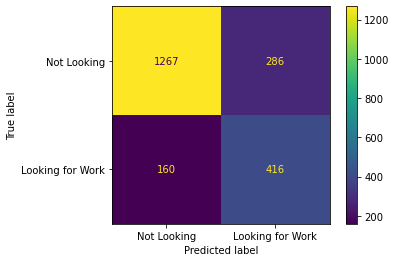

In [27]:
np.random.seed(1)
plot_confusion_matrix(pipe, 
                      X_test, 
                      y_test,
                      display_labels=['Not Looking', 'Looking for Work']);


rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)

print(f"Recall Score: {rec:.2f}  |  Precision Score: {prec:.2f}",\
     f" |  f1 Weighted Score: {f1_score(y_test, y_pred, average='weighted'):.2f}");

#### Interpretation:
1. Looking at the confusion matrix, we see that our model did fairly well. In particular, our model misclassified only 18% of individuals not looking for work, and 27% of individuals looking for work.


2. In particular, our precision score was 59%, which means that **"When my model predicted someone to be Looking for Work, it was accurate 59% of the time."**. Although this isn't an amazing score, it can still be useful for a variety of potential business cases. In the narrative that we are using this model to help better allocate the time of our recruiters, having a 59% chance that every candidate the recruiter is talking to is looking for a job, can be a huge time saver. This is compared to not using the model and having only a 25% chance of reaching out to someone at random and them currently looking for work.


3. In addition, we can look at the recall score. At 72%, this means that **"When an individual was looking for work, our model accurately classified them 72% of the time."** This is also an important metric for the above business situation. In particular, we would want to minimize our False Negatives, aka: when our model inaccurately predicts someone who is looking for work. For the business, they may want a high recall in order to avoid missing out on good candidates.


4. All together, we can look at the weighted f1 score of **80%** because our business case revolves around maximizing both precision and recall. Note that since this is an imbalanced dataset, our f1 score calculates the metric for each label, weighs it proportionally to its relative frequency, and outputs a score that, in this case, is not in-between the recall and precision score. 
______
### 3. Feature Importance.
For interpretability, it is always important to try to extract feature importance from a model. In other words, what features were deemed the "most important" for our model. For this task, I use sklearn's built-in permutation_importance over 100 iterations

In [63]:
np.random.seed(1)

r = permutation_importance(pipe, X_test, y_test,
                           n_repeats=100)

'''
Code Source: https://scikit-learn.org/stable/modules/permutation_importance.html
'''
print(f"{'Feature':^25}{'Mean':^8}{'std':^13}")
print('-'*(25+8+13))
for i in r.importances_mean.argsort()[::-1]:
    print(f"{X.columns[i]:<25}",\
          f"{r.importances_mean[i]:.2f}",\
          f" +/- {r.importances_std[i]:.2f}")

         Feature           Mean       std     
----------------------------------------------
city_development_index    0.09  +/- 0.01
city                      0.04  +/- 0.00
company_size              0.02  +/- 0.00
major_discipline          0.02  +/- 0.00
education_level           0.01  +/- 0.00
company_type              0.01  +/- 0.00
last_new_job              0.01  +/- 0.00
relevent_experience       0.00  +/- 0.00
enrolled_university       0.00  +/- 0.00
gender                    0.00  +/- 0.00
enrollee_id               0.00  +/- 0.00
experience                -0.00  +/- 0.00
training_hours            -0.00  +/- 0.00


#### Results:
1. Interestingly enough, it looks like the city_development_index is the most impactful when making this prediction. In order to better understand the relationship between city_development_index and the target variable, it is helpful to look at a quick plot:

<img src="Images/EDA_City_Development_Index.png" alt="Drawing" style="width: 400px;"/>

2. As we can see, it looks like as the city_development_index increases, people are less likely to be looking for a job. This makes sense as a higher city development index could mean that people are more content with their current location. Note that this assumes that looking for work tends to be a factor of location as well as things related to your current job (job type, company size, etc). In addition, this graph could be interpreted on the flip-side. People in cities with a low development index are much more likely to be seeking a new job.

3. Besides city_development_index, the city, company_size and major_discipline also had a relatively high impact.

_________
# Conclusion: <a id='conclusion'></a>  

## Summary:
With a goal of implementing a variety of skills learned in my Machine Learning Lab, this project focused on HR data to help identify whether or not someone is currently looking for a job. After extensive EDA, I decided to construct three separate pipelines for preprocessing: one for each type of feature (numerical, categorical, ordinal). Next, although my data was imbalanced, I decided against using oversampling with SMOTE because it didn't lead to a noticeable improvement (as shown with cross validation). Finally, I tried several of ensemble techniques and decided that my final model would be the original RandomForestClassifier that I found in my RandomizedSearchCV. Note that I used a weighted f1 score as my metric to compare models with as it equally values precision and recall scores while taking into consideration that the data is imbalanced.

## Common Questions:
1. **Why does any of this matter?**
    - **I am glad you asked!** Although this project was primarily as a tool to explore different modeling methods on fairly clean data, we did it in a way focusing on a hypothetical scenario where this data would be used. This is helpful when working on actual business problems, because it is important to iterative over different models and have a consistent and **relevant** metric that we compare each model with. This metric is relevant to the business use-case.


2. **Why did I impute categorical variables to be "missing" instead of "most_frequent"?**
   - I chose to do this because imputing the most_frequent can add bias to our model. In essence, we are assuming that the entry was empty because of a clerical error, which could, in itself, have an impact on our target variable. One could argue that me imputing "missing" could be adding my own bias that these weren't just clerical errors and have an equally negative impact on our model. In the end, it was personal preference.
   - **Follow up: Why did I not impute missing for numerical as well?**
       - With numerical data, we need slightly different imputing strategies. This is because we want our end result to be all numerical. Therefore, I chose to use an IterativeImputer which I explain below.



3. **Why did I use an IterativeImputer for my numerical data?**
    - This decision was made primarily because I did not want to have a single rule of only imputing the median. Instead, an IterativeImputer works in the following way:
        - Say you have 4 columns ('a', 'b', 'c', 'd') and one column ('d') is missing some values. An iterative imputer will train a new model trying to predict the missing values in 'd' with the values in ('a', 'b', 'c').


5. **Why did I use a QuantileTransformer on my numerical data?**
    - ["Many machine learning algorithms prefer or perform better when numerical variables have a Gaussian or standard probability distribution."](https://machinelearningmastery.com/quantile-transforms-for-machine-learning/). In particular, I included a LogisticRegression model in my RandomizedSearchCV which assumes that the data is normalized.


6. **Why did I use cross_val_score?**
    - I decided to use cross_val_score because I felt that it was a better route of getting a good sense of how well a model performs in order to properly compare it to other modeling strategies. In addition, it was a quick way to compare different metrics like Recall and Precision to visualize the trade-off between models.
    
    
7. **Why did neither of my Ensemble Techniques lead to a significantly better model?**
   - A lot of this has to do with fine tuning these models. For example:
       - The VotingClassifier could potentially do much better if I spend more time deciding which (and how many) models to include. In addition, there are hyper-parameters that come with this model that could also be tweaked within a RandomizedSearchCV.
       - The BaggingClassifier could also be tweaked more since I did not experiment iteratively through different parameter ranges.
       - The Boosting probably has the most potential for success, but again, it involves extensive tweaking of hyper parameters and model selection.




## Future Steps
1. As Boosting has taken Kaggle competitions by stride, it would be interesting to see more exploration on how boosting can further improve this model. In particular, I am interested to see how XGBoost and CatBoost can be used to solve this problem.
2. Further exploration on other feature engineering techniques that could improve predictability.
3. Exploring other approaches for counteracting imbalanced datasets.